In [1]:
%load_ext autoreload
%autoreload 2

# Business-as-usual analysis

In [94]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from ema_workbench import load_results
from unbreakable.analysis.analyzer import *
from unbreakable.analysis.visualizer import *
sns.set_theme(style="ticks")

In [95]:
# Parameters for report writing
savefig = False
savetab = False
figures_folder = '../../reports/Dominica/figures/'

## Load results

In [96]:
# Load results
country = 'Dominica'
n_scenarios = 3000
n_policies = 0
results = load_results(f'../../experiments/{country}/scenarios={n_scenarios}, policies={n_policies}.tar.gz')

# Prepare outcomes
outcomes = prepare_outcomes(results, add_uncertainties=False, add_policies=False)

## EDA

### Single scenario, single district 

In [97]:
# Print all outcomes for a single scenario
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)
# df.drop(columns=['weighted_vuln_quint', 'weighted_vuln_dec'], inplace=True)
numeric_columns = df.columns[3:-1].tolist()
df[numeric_columns].round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,tot_exposed_asset,tot_asset_surv,expected_loss_frac,n_affected_people,annual_average_consumption,poverty_line_adjusted,district_pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap_initial,new_poverty_gap_all,annual_average_consumption_loss,annual_average_consumption_loss_pct,mean_recovery_rate,r,n_new_poor_increase_pp
district,,,,,,,,,,,,,,,,,,,,,
City of Roseau,"14,948.43","16,121,516.10","13,201,321.53","683,356,438.97","800,663,575.90",0.02,"1,264.15","13,651.53","5,317.23","16,250,216.12","1,952.00",38.00,15.00,20.69,20.89,20.85,"1,044.28",8.37,0.30,1.43,0.10
Rest of St George,"5,496.98","7,908,981.92","6,132,032.62","319,580,036.92","290,275,702.88",0.02,349.92,"17,966.38","6,858.94","7,599,613.28",892.00,52.00,17.00,26.54,27.05,26.74,"1,752.39",9.30,0.27,2.41,0.31
St. John,"5,322.70","3,339,226.72","2,376,371.29","146,917,090.94","290,195,853.85",0.02,303.58,"8,118.78","3,154.05","3,493,688.42",564.00,31.00,10.00,15.16,15.74,15.60,782.77,11.74,0.20,0.59,0.19
St Peter,"1,502.04","1,853,485.83","1,471,986.89","81,914,004.37","53,869,252.29",0.02,94.25,"16,389.16","9,473.39","1,947,915.02",356.00,21.00,1.00,24.74,24.93,24.86,"1,561.79",9.09,0.26,2.42,0.07
St. Joseph,"5,891.05","4,276,163.10","3,278,491.76","175,268,750.64","172,708,190.03",0.02,457.19,"9,239.21","6,322.37","4,167,890.89","2,739.00",217.00,0.00,32.92,33.30,33.30,717.10,7.74,0.22,0.87,0.00
St Paul,"8,719.30","9,044,988.16","7,463,276.95","382,090,503.45","458,724,655.23",0.02,457.87,"14,179.57","5,189.22","9,086,112.17","2,830.00",112.00,8.00,33.32,33.60,33.50,"1,630.01",9.03,0.27,1.60,0.09
St. Luke,"1,452.45","972,530.87","759,456.50","41,700,575.95","54,234,426.75",0.02,114.51,"9,442.01","4,790.22","991,639.70",193.00,19.00,8.00,41.77,42.13,40.74,663.20,7.20,0.29,0.88,0.55
St. Mark,"2,114.61","3,068,444.78","2,460,477.91","125,273,541.49","92,369,121.62",0.02,145.10,"16,694.07","8,449.30","2,979,004.82",539.00,39.00,7.00,19.60,20.22,20.13,"1,695.67",10.37,0.28,2.14,0.33
St. Patrick,"8,477.02","3,373,898.19","2,533,056.49","149,203,255.36","316,146,421.73",0.02,625.25,"4,641.74","2,940.21","3,548,053.41","3,475.00",302.00,0.00,31.86,32.62,32.62,405.13,10.76,0.25,0.26,0.00


In [98]:
# Let's examine a single scenario in details
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)

# And a single district as an example
district = 'City of Roseau'
print('District: ', district)
total_population = round(df.loc[district, 'total_population'])
n_affected = round(df.loc[district, 'n_affected_people'])
print('Total population: ', total_population)
print('Number of affected people: ', n_affected)

n_poor_initial = round(df.loc[district, 'n_poor_initial'])
n_new_poor = round(df.loc[district, 'n_new_poor'])
pct_poor_initial = round(n_poor_initial / total_population * 100, 2)
pct_new_poor = round((n_new_poor + n_poor_initial) / total_population * 100, 2)
pct_poor_increase = round(n_new_poor / total_population * 100, 2)
initial_poverty_gap = round(df.loc[district, 'initial_poverty_gap'], 2)
new_poverty_gap_init = round(df.loc[district, 'new_poverty_gap_initial'], 2)
new_poverty_gap_all = round(df.loc[district, 'new_poverty_gap_all'], 2)
print()
print('Number of poor: ', n_poor_initial)
print('Number of new poor: ', n_new_poor)
print(f'Percentage of poor: {pct_poor_initial}%')
print(f'Percentage of new poor: {pct_new_poor}%')
print(f'Percentage of increase in poor: {pct_poor_increase}%')
print('Initial poverty gap: ', initial_poverty_gap)
print('New poverty gap initial poor: ', new_poverty_gap_init)
print('New poverty gap all poor: ', new_poverty_gap_all)

annual_average_consumption = round(df.loc[district, 'annual_average_consumption'])
annual_average_consumption_loss = round(df.loc[district, 'annual_average_consumption_loss'])
annual_average_consumption_loss_pct = round(df.loc[district, 'annual_average_consumption_loss_pct'])
print()

print('Annual average consumption: ', annual_average_consumption)
print('Annual average consumption loss: ', annual_average_consumption_loss)
print(f'Annual average consumption loss percentage: {annual_average_consumption_loss_pct}%')

print()
r = round(df.loc[district, 'r'], 2)
print('Socio-economic resilience: ', r)

District:  City of Roseau
Total population:  14948
Number of affected people:  1264

Number of poor:  1952
Number of new poor:  15
Percentage of poor: 13.06%
Percentage of new poor: 13.16%
Percentage of increase in poor: 0.1%
Initial poverty gap:  20.69
New poverty gap initial poor:  20.89
New poverty gap all poor:  20.85

Annual average consumption:  13652
Annual average consumption loss:  1044
Annual average consumption loss percentage: 8%

Socio-economic resilience:  1.43


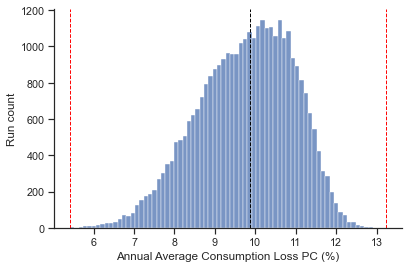

In [99]:
annotated_hist(outcomes, savefig=False, annotate=False)

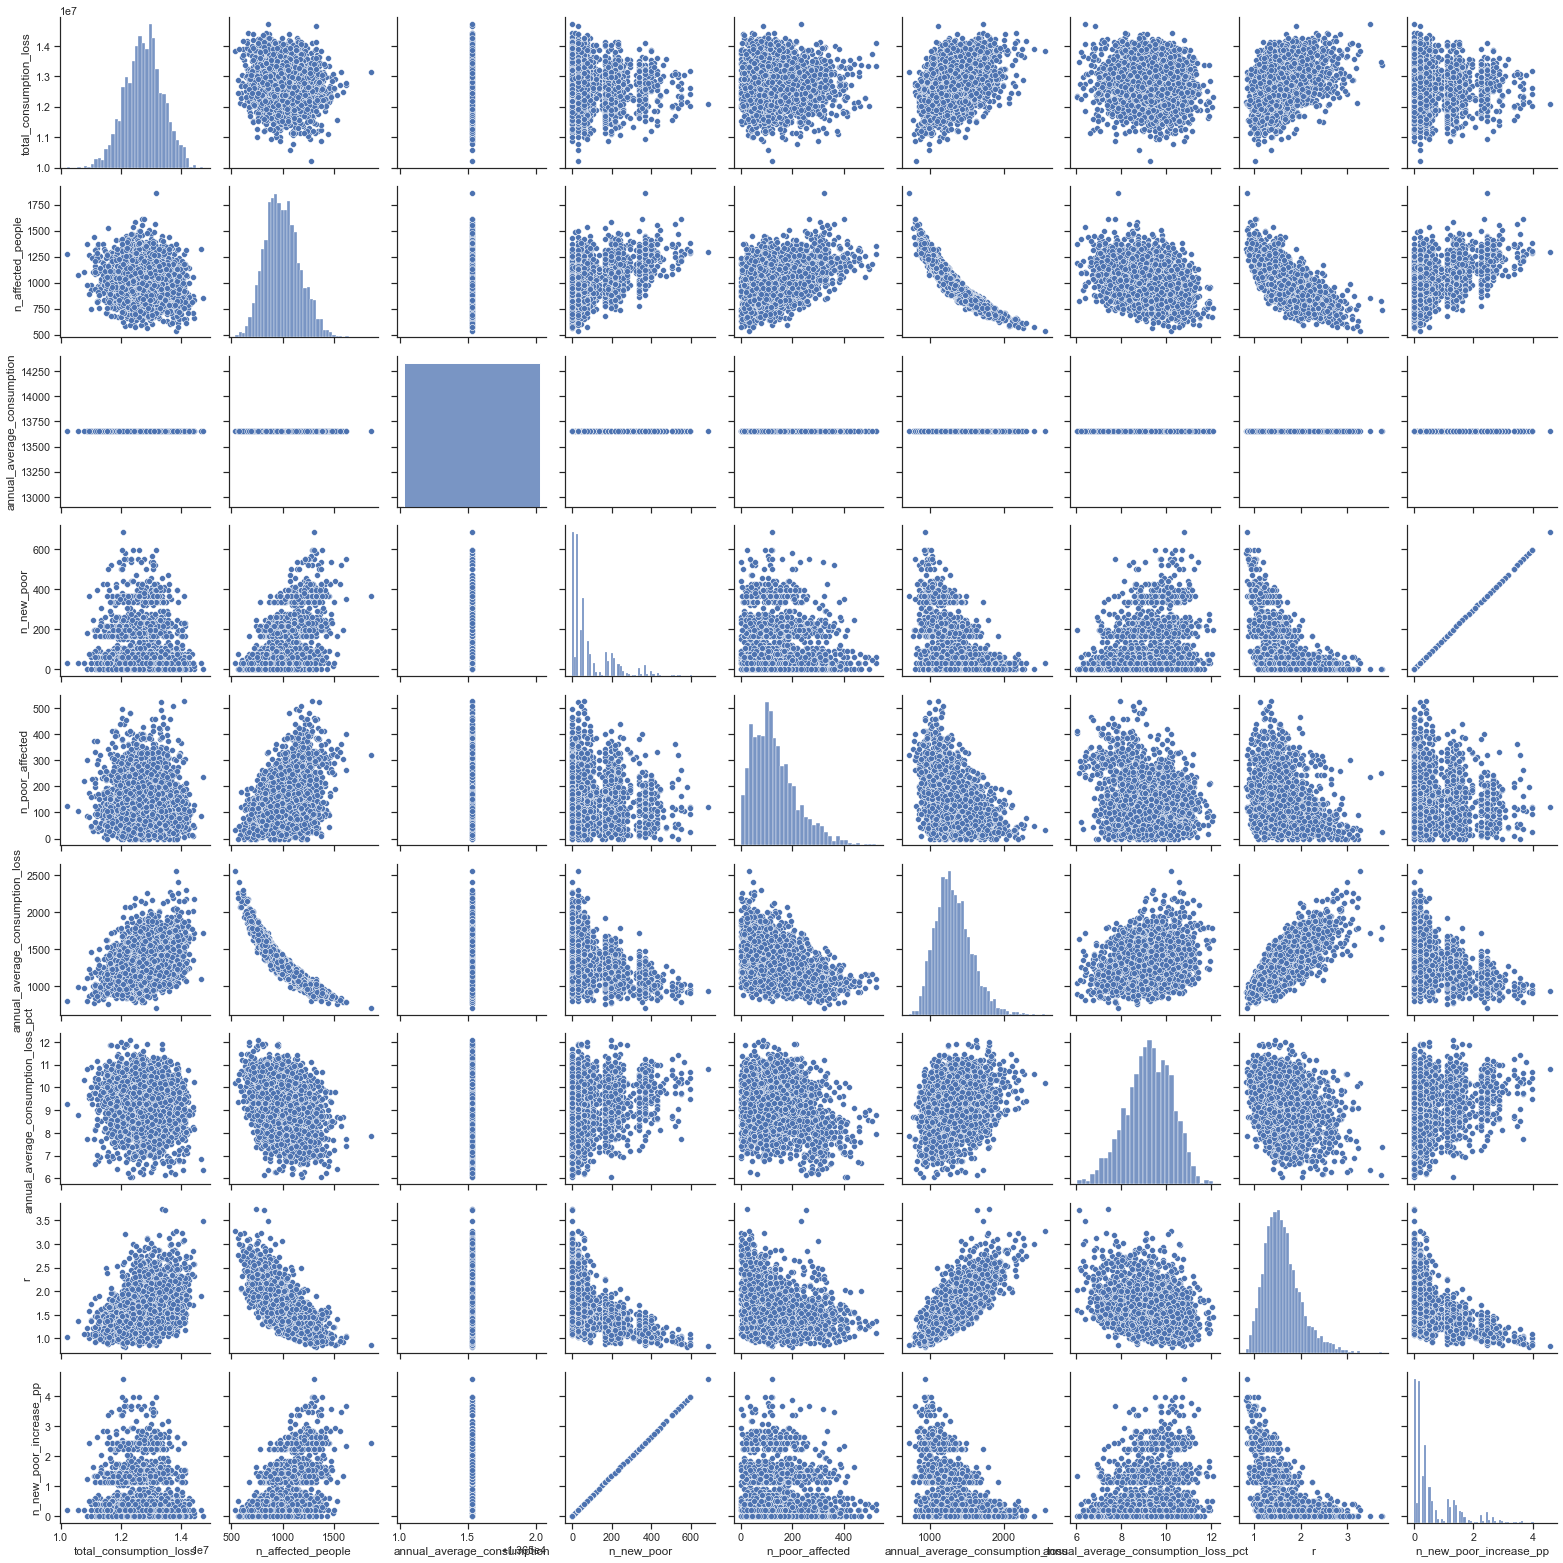

In [100]:
# Print all outcomes for a single scenario
district = 'City of Roseau'
df = outcomes[outcomes['district'] == district].copy()
df.drop(columns=['years_in_poverty'], inplace=True)
columns_of_interest = ['total_consumption_loss', 
                       'n_affected_people', 'annual_average_consumption', 'n_new_poor', 'n_poor_affected',
                       'annual_average_consumption_loss', 'annual_average_consumption_loss_pct', 'r', 'n_new_poor_increase_pp']
sns.pairplot(df[columns_of_interest])
plt.tight_layout();

### Multiple scenarios & multiple districts

In [101]:
# Let's aggregate across scenarios and take the mean
outcomes.iloc[:, 2:-1].groupby('district').mean(numeric_only=True).round(2).sort_values(by='r', ascending=False)[['r']]

,r
district,
St Peter,2.38
Rest of St George,2.23
St. Mark,2.09
City of Roseau,1.62
St Paul,1.29
St. Luke,1.05
St. Joseph,0.99
St. John,0.74
St. Andrew,0.43


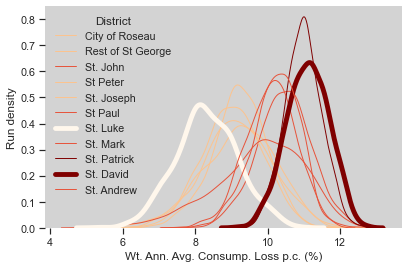

In [9]:
coloured_density_plots(outcomes, savefig, scheme='fisher_jenks', k=4)

In [10]:
tab = outcomes.iloc[:, 2:-1].groupby('district').describe().round(2)
column = 'n_new_poor'
tab = tab.sort_values(by=(column, 'mean'), ascending=False)
tab[[column]].iloc[:,1:].style.format("{:,.2f}")

## Weeks in poverty & Number of new poor

In [48]:
average_years_in_poverty = {}
for district in outcomes['district'].unique():
    df = outcomes[outcomes['district'] == district].copy()
    total_years_in_poverty = {}
    for d in df['years_in_poverty']:
        for key, value in d.items():
            total_years_in_poverty[key] = total_years_in_poverty.get(key, 0) + value
    average_years_in_poverty[district] = {k: v / len(df) for k, v in total_years_in_poverty.items()}
average_years_in_poverty = pd.DataFrame(average_years_in_poverty).T

In [59]:
average_years_in_poverty

,0,1,2,3,4,5,6,7,8,9,10
District,,,,,,,,,,,
City of Roseau,0.0,0.0,0.0,0.000,34.319,12.078,18.816,20.328,0.000,1.818,0.0
Rest of St George,0.0,0.0,0.0,0.000,0.000,6.096,1.855,0.000,7.297,2.230,0.0
St. John,0.0,0.0,0.0,0.000,0.000,7.770,3.499,1.895,0.000,0.000,0.0
St Peter,0.0,0.0,0.0,1.026,0.000,0.000,0.000,0.894,0.000,0.000,0.0
St. Joseph,0.0,0.0,0.0,0.000,0.000,2.946,0.000,0.000,0.000,0.000,0.0
St Paul,0.0,0.0,0.0,17.475,0.000,0.000,3.969,8.668,0.000,0.000,0.0
St. Luke,0.0,0.0,0.0,0.000,0.647,4.210,3.192,1.396,0.000,0.000,0.0
St. Mark,0.0,0.0,0.0,0.000,0.000,0.965,0.000,0.000,6.070,0.000,0.0
St. Patrick,0.0,0.0,0.0,0.000,1.937,0.000,2.280,0.000,0.000,0.000,0.0


In [50]:
average_years_in_poverty = get_weeks_in_poverty_tab(outcomes)

if savetab:
    # average_years_in_poverty.rename({'Anse-La-Raye & Canaries': 'Anse-La-Raye \& Canaries'}, inplace=True, axis=0)
    average_years_in_poverty.astype(int).style\
        .background_gradient(cmap='Blues', axis=0)\
        .set_caption('Average Years in Poverty By District')\
        .to_latex(f'../reports/tables/av_years_in_pov.tex',
                  # escape=False,
                  caption='Average Years in Poverty By District',
                  label='tab:av_years_in_pov',
                  convert_css=True,
                  multicol_align="|c|",
                  hrules=True,
                  position_float="centering")

In [51]:
# Number of people in poverty for 1 / 3 / 5 years

In [62]:
# More than 1 year in poverty
n_years = 1
average_years_in_poverty.iloc[:,n_years:].sum(axis=1)

District
City of Roseau       87.359
Rest of St George    17.478
St. John             13.164
St Peter              1.920
St. Joseph            2.946
St Paul              30.112
St. Luke              9.445
St. Mark              7.035
St. Patrick           4.217
St. David            15.751
St. Andrew           37.209
dtype: float64

In [63]:
# More than 3 years in poverty
n_years = 3
average_years_in_poverty.iloc[:,n_years:].sum(axis=1)

District
City of Roseau       87.359
Rest of St George    17.478
St. John             13.164
St Peter              1.920
St. Joseph            2.946
St Paul              30.112
St. Luke              9.445
St. Mark              7.035
St. Patrick           4.217
St. David            15.751
St. Andrew           37.209
dtype: float64

In [64]:
# More than 5 years in poverty
n_years = 5
average_years_in_poverty.iloc[:,n_years:].sum(axis=1)

District
City of Roseau       53.040
Rest of St George    17.478
St. John             13.164
St Peter              0.894
St. Joseph            2.946
St Paul              12.637
St. Luke              8.798
St. Mark              7.035
St. Patrick           2.280
St. David            15.751
St. Andrew           22.186
dtype: float64

In [65]:
average_years_in_poverty.astype(int).style\
        .background_gradient(cmap='Blues', axis=0)\
        .set_caption('Average Years in Poverty By District')

,0,1,2,3,4,5,6,7,8,9,10
District,,,,,,,,,,,
City of Roseau,0,0,0,0,34,12,18,20,0,1,0
Rest of St George,0,0,0,0,0,6,1,0,7,2,0
St. John,0,0,0,0,0,7,3,1,0,0,0
St Peter,0,0,0,1,0,0,0,0,0,0,0
St. Joseph,0,0,0,0,0,2,0,0,0,0,0
St Paul,0,0,0,17,0,0,3,8,0,0,0
St. Luke,0,0,0,0,0,4,3,1,0,0,0
St. Mark,0,0,0,0,0,0,0,0,6,0,0
St. Patrick,0,0,0,0,1,0,2,0,0,0,0


In [43]:
# Get the number of new poor in each district
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
d = {}
for district in districts:
    df = outcomes[outcomes['district'] == district]
    d[district] = df['n_new_poor'].values.tolist()

In [44]:
# Make a coloured table
tab = pd.DataFrame(d).describe().T.sort_values('mean', ascending=False).round(2).drop('count', axis=1)
tab.style.background_gradient(cmap='Blues', subset=['mean'])\
         .background_gradient(cmap='Reds', subset=['std'])\
         .background_gradient(cmap='Greens', subset=['min'])\
         .background_gradient(cmap='Greens', subset=['25%'])\
         .background_gradient(cmap='Greens', subset=['50%'])\
         .background_gradient(cmap='Greens', subset=['75%'])\
         .background_gradient(cmap='Greens', subset=['max'])\
         .format(decimal='.', thousands=',', precision=0)

,mean,std,min,25%,50%,75%,max
City of Roseau,87,109,0,15,46,107,580
St. Andrew,37,33,0,6,37,62,184
St Paul,30,28,0,8,28,45,145
Rest of St George,18,11,0,10,16,24,60
St. David,16,17,0,3,8,27,113
St. John,13,14,0,0,10,21,63
St. Luke,10,7,0,4,9,14,37
St. Mark,7,6,0,2,7,11,34
St. Patrick,4,6,0,0,0,8,29
St. Joseph,3,5,0,0,0,10,29


## Average vulnerability

In [21]:
# vulnerability_by_quintile = get_average_weighted_vulnerability(outcomes, quintile=True)
# vulnerability_by_quintile.T.style.format("{:.2f}")

In [22]:
# vulnerability_by_decile = get_average_weighted_vulnerability(outcomes, quintile=False)
# vulnerability_by_decile.T.style.format("{:.2f}")

## Raincloud plots

Raincloud plot is a combination of a boxplot, a kernel density plot, and a dot plot. It is a great way to visualize the distribution of the data. Especially, when the distribution is skewed and you have a lot of data points.

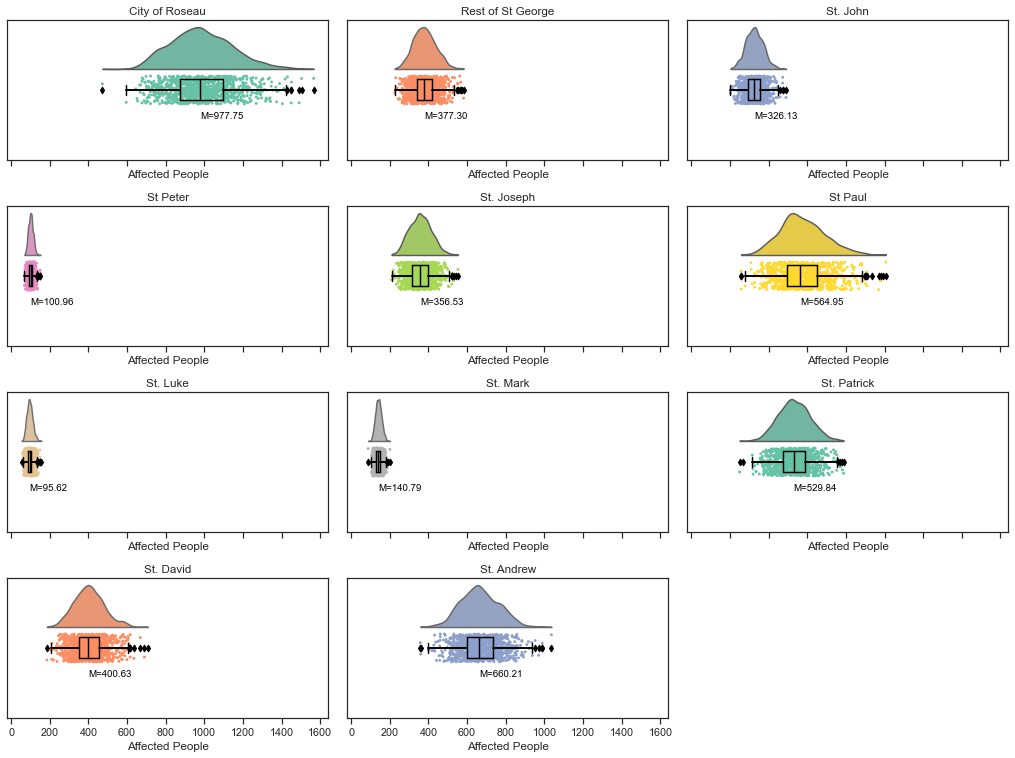

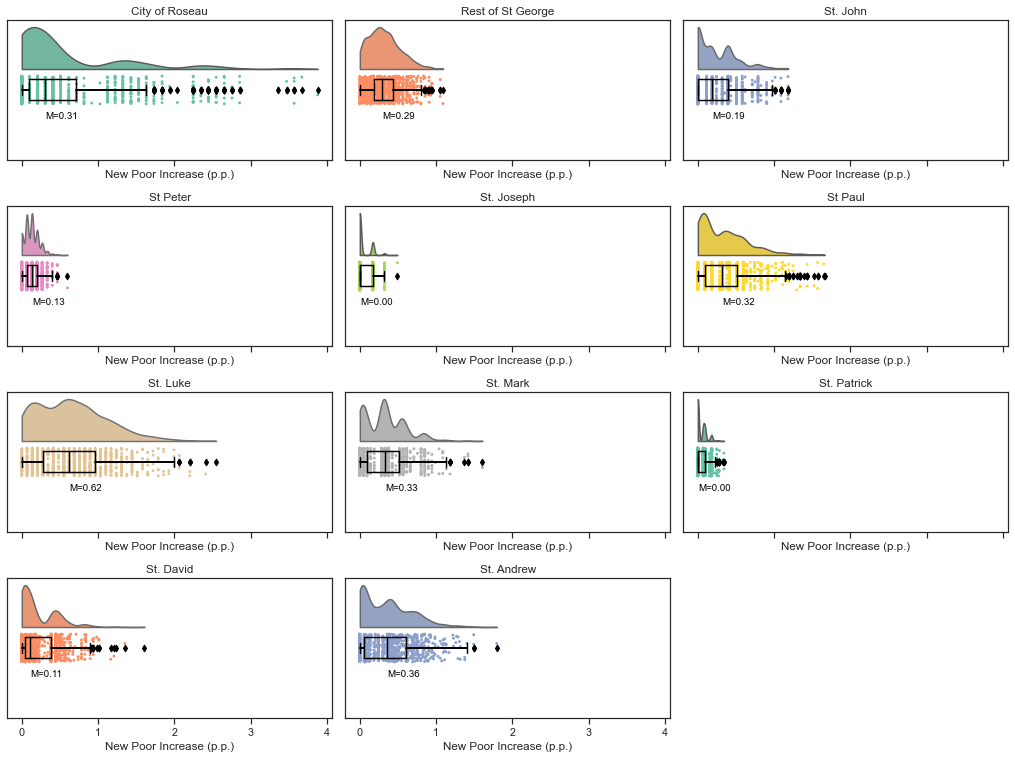

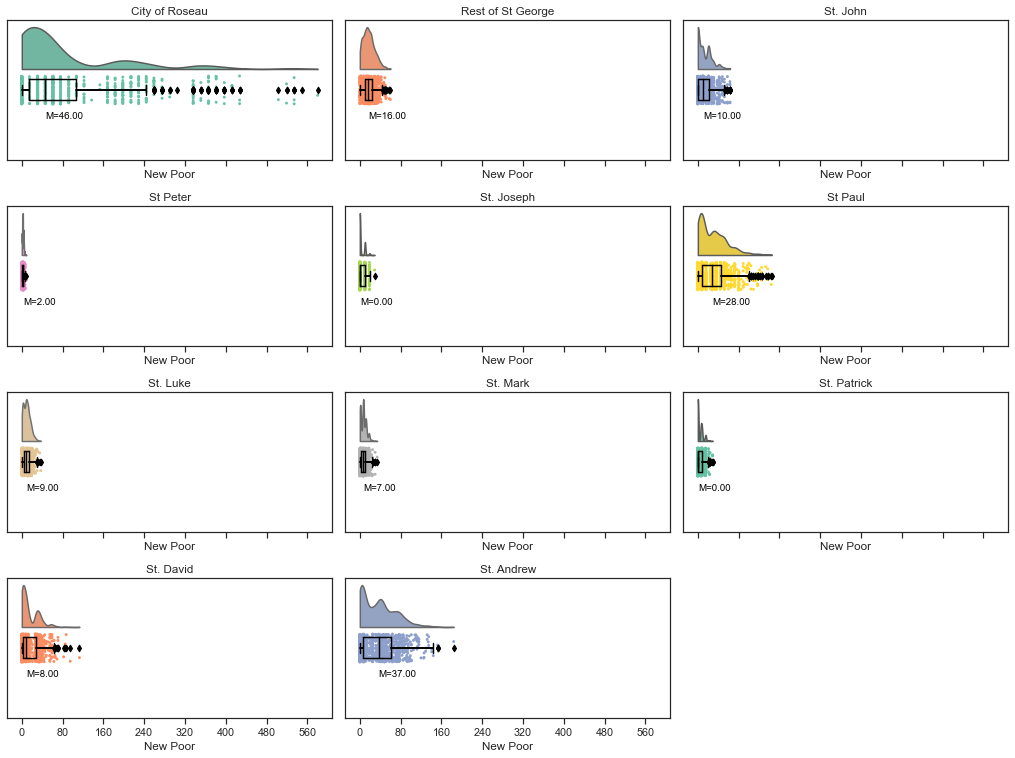

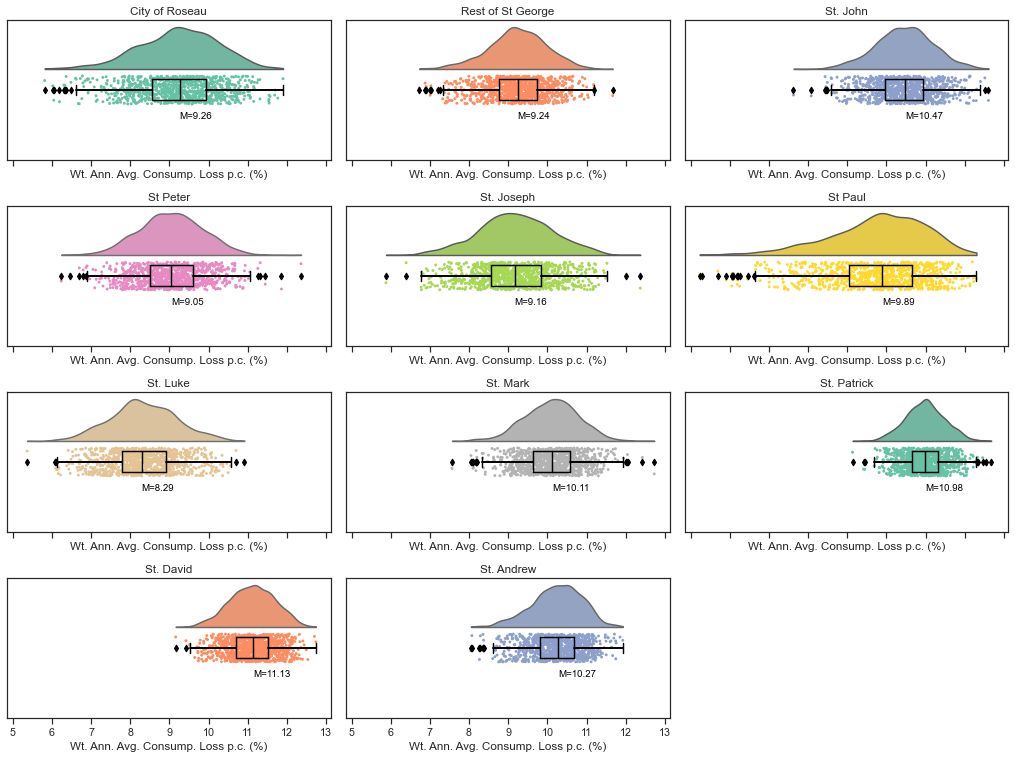

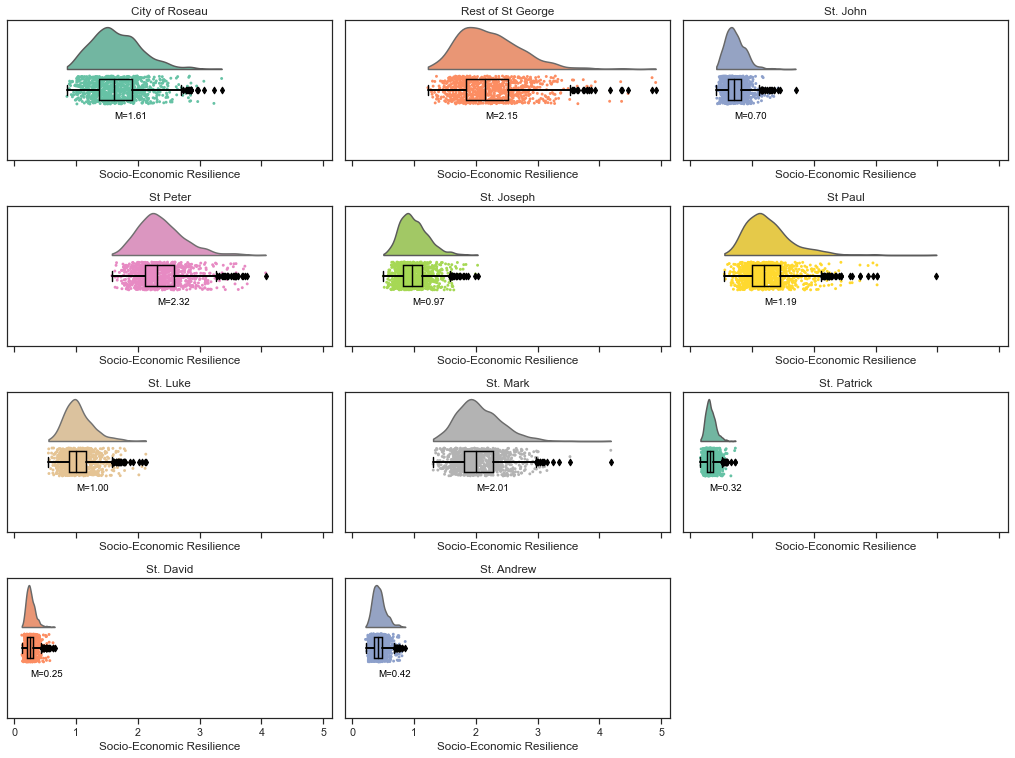

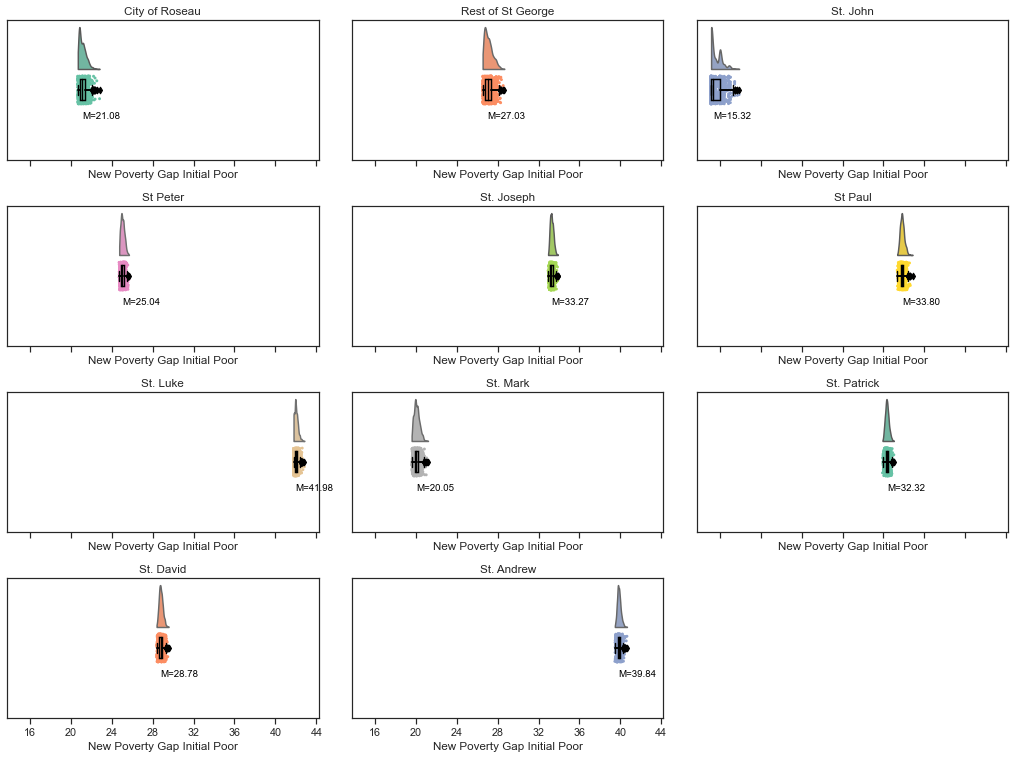

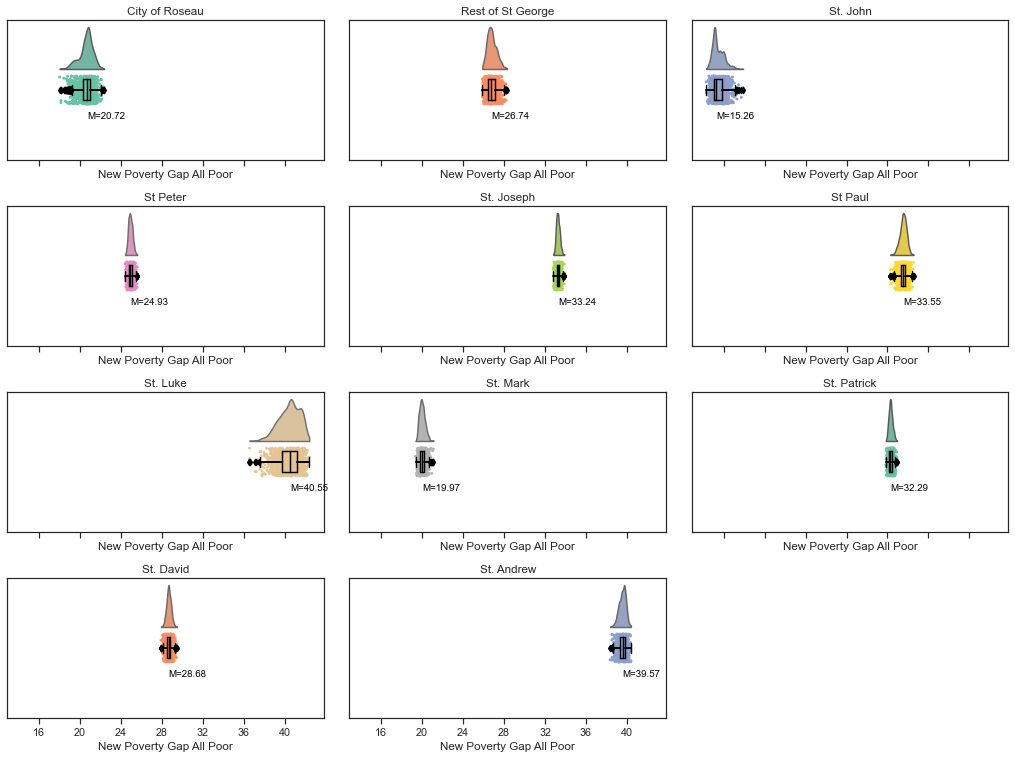

In [66]:
raincloud_plot(outcomes, savefig=savefig)

## Outcomes spatially

Another way to visualize the outcomes is to use choropleth maps. These maps are useful when you have data that is aggregated by a geographic area. For example, if we have data on how many people became poor after a disaster in the districts of Saint Lucia, we could use a choropleth map to show these numbers.  

What is important to remember is that **these maps do not show the variance** within each district. Instead, they show the mean or median value for each district.

In [85]:
# Get the country shapefile and aggregated outcomes
aggregation = 'median'
country = 'Dominica'
aggregated_outcomes = get_spatial_outcomes(outcomes=outcomes, country=country, aggregation=aggregation)

# Convert to be in millions
aggregated_outcomes[['tot_exposed_asset', 'total_consumption_loss']] /= 1000000
aggregated_outcomes[['tot_exposed_asset', 'total_consumption_loss']] = aggregated_outcomes[['tot_exposed_asset', 'total_consumption_loss']].round(2)

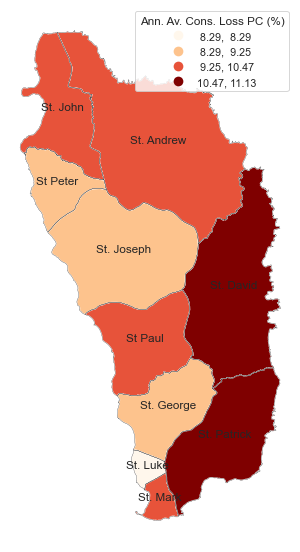

In [90]:
k = 4

column = 'annual_average_consumption_loss_pct'
title = 'Ann. Av. Cons. Loss PC (%)'
cmap = 'OrRd'

scheme = 'fisher_jenks'
ax = aggregated_outcomes.plot(column=column, scheme=scheme, k=k, cmap=cmap, legend=True, figsize=(10,10), legend_kwds={"title":title, "loc" : "upper right"})
aggregated_outcomes.plot(ax=ax, color='none', edgecolor='black', linewidth=0.25)
ax.axis('off')
for idx, row in aggregated_outcomes.iterrows():
    ax.annotate(text=row['NAME'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=12)
if savefig:
    plt.savefig(figures_folder + f'soc_econ_res_map.png', dpi=300, bbox_inches='tight')

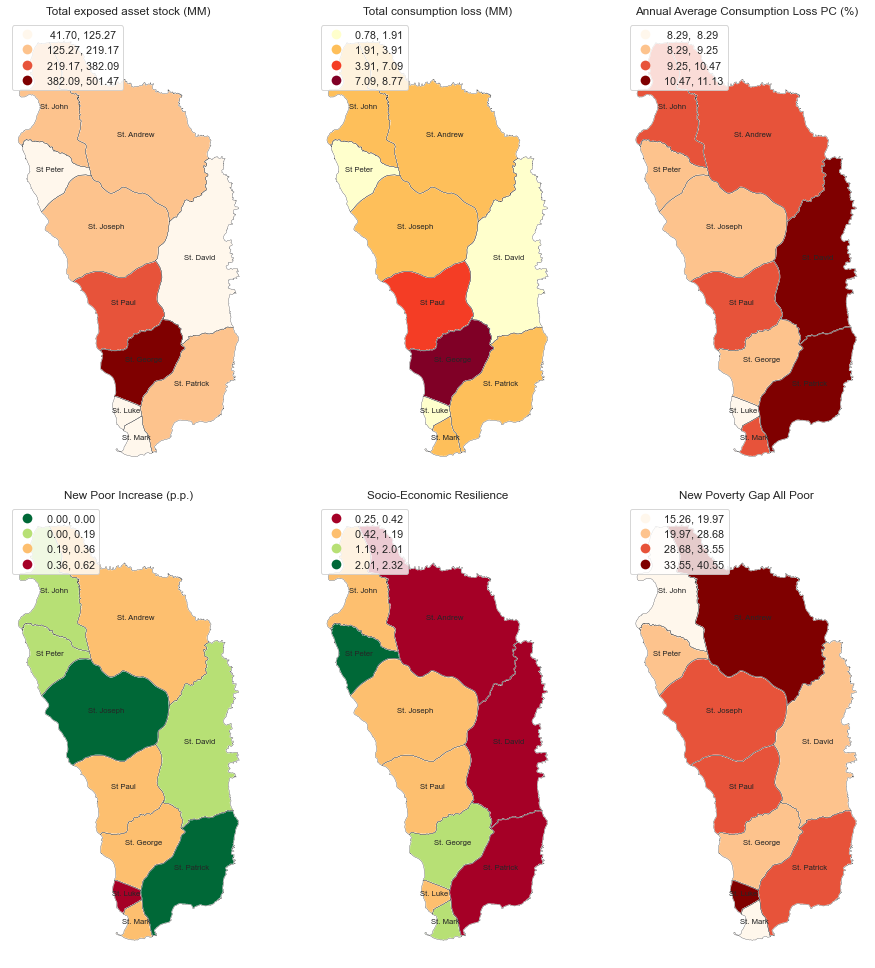

In [91]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 14))

outcomes_to_plot = [
    'tot_exposed_asset',
    'total_consumption_loss',
    'annual_average_consumption_loss_pct',
    'n_new_poor_increase_pp',
    'r',
    'new_poverty_gap_all']

titles = ['Total exposed asset stock (MM)',
          'Total consumption loss (MM)',
          # 'Wt. Ann. Avg. Consump. Loss p.c. (%)',
          'Annual Average Consumption Loss PC (%)',
          'New Poor Increase (p.p.)',
          'Socio-Economic Resilience',
          'New Poverty Gap All Poor']

cmaps = ['OrRd', 'YlOrRd', 'OrRd', 'RdYlGn_r', 'RdYlGn', 'OrRd']

k = 4
for i, outcome in enumerate(outcomes_to_plot):
    aggregated_outcomes.plot(column=outcome, scheme='fisher_jenks', cmap=cmaps[i], k=k, ax=ax[i//3, i % 3], legend=True, legend_kwds={"loc": "upper left"})
    aggregated_outcomes.plot(ax=ax[i//3, i % 3], color='none', edgecolor='black', linewidth=0.25)
    ax[i//3, i % 3].set_title(titles[i])
    ax[i//3, i % 3].axis('off')
    for idx, row in aggregated_outcomes.iterrows():
        ax[i//3, i % 3].annotate(text=row['NAME'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)

# fig.suptitle(f'{aggregation.capitalize()} of 3,000 replications', fontsize=16)

fig.tight_layout()
if savefig:
    plt.savefig(figures_folder +
        f'{aggregation}_outcomes_spatially.png', dpi=300, bbox_inches='tight')

A bivariate or bi-variate choropleth helps to visualise relations between two variables spatially. 

In [37]:
# Load asset damage data
asset_damage = pd.read_excel('../data/processed/asset_damage/Saint Lucia.xlsx')
asset_damage['district'].replace({'AnseLaRayeCanaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
gdf = pd.merge(aggregated_outcomes, asset_damage, left_on='NAME_1', right_on='district', how='left')

In [92]:
# x_name = 'r'
# y_name = 'pml'
# x_label = 'Soc.-econ. res.'
# y_label = 'PML'

# tab = bivariate_choropleth(gdf.copy(), x_name, y_name, x_label, y_label, scheme='fisher_jenks', figsize=(7,6), return_table=True)
# if savefig:
#     plt.savefig('../reports/figures/analysis/bivariate_choropleth.png', dpi=300, bbox_inches='tight')

In [93]:
# nine_quadrants_plot(gdf.copy(), x_name, y_name)
# plt.xlabel('Socio-Economic Resilience')
# plt.ylabel('PML')
# if savefig:
#     plt.savefig('../reports/figures/analysis/9_quadrants.png', dpi=300, bbox_inches='tight')